In [10]:
import os 
print(os.getcwd())

import numpy as np 
import matplotlib.pyplot as plt
import pdb
from numba import njit

/home/pdavid/Bureau/Code/hybrid3d/rapid_term


First of all a little test to show the properties of the integration of the Green's function over closed surfaces, we show this in 2D

Definition of the Green's function 
$$
\nabla^2 G(\mathbf{x}, \mathbf{x}^*) = -\delta(\mathbf{x} - \mathbf{x}^*)
$$
Resulting in
$$
G(\mathbf{x}, \mathbf{x}^*) = \dfrac{1}{2 \pi}ln \left( \dfrac{a}{||\mathbf{x} - \mathbf{x}^*||} \right)
$$
where $a$ is an arbitrary constant of integration

We wanna show that for $a=R$, where $R$ is the radius of the circumference over which the Green's function is integrated, we obtain:
$$
 P_j = \begin{cases}
      R ln \Big( \dfrac{R}{||\mathbf{x} - \mathbf{x}_j||} \Big) & \text{if } ||\mathbf{x} - \mathbf{x}_j|| > R_j\\
      0 & \text{if } ||\mathbf{x} - \mathbf{x}_j|| \leq R_j\\
    \end{cases}
$$

In [11]:
#%% - check dipoles
N=1000
d_t=2*np.pi/N #angle differential
theta=np.linspace(0,2*np.pi-d_t,N) #array of angles 
R=4 #radius of circle
x=np.linspace(0,5*R,100) #distance to origin 
dipol=np.array([]) #array for the double layer potential 
single=np.array([]) #array for the single layer potential
for k in x:
    c=0
    integral=0
    S=0
    for i in theta:
        x_c=R*np.cos(i)
        y_c=R*np.sin(i)
        r=-np.array([x_c,y_c])+np.array([0,k])
        d=np.linalg.norm(r)
        er=r/d
        
        grad_G=1/(2*np.pi*d)
        S+=np.log(R/d)/2/np.pi*R*d_t
        n=np.array([np.cos(i), np.sin(i)])
        integral+=np.dot(er,n)*grad_G*R*d_t
        c+=1
    
    dipol=np.append(dipol,integral)
    single=np.append(single, S)
    

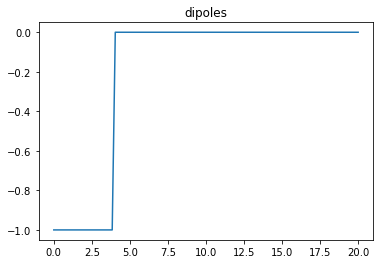

<ipython-input-12-9c86ce4e5baa>:3: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(x,R*np.log(R/x), label='$R log(\dfrac{R}{x})$')


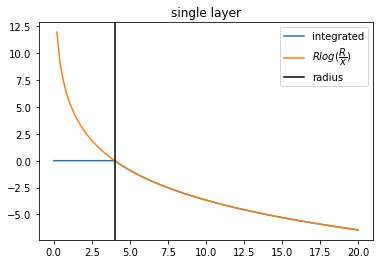

In [12]:
plt.plot(x,dipol); plt.title("dipoles");plt.show()
plt.plot(x,single, label='integrated')
plt.plot(x,R*np.log(R/x), label='$R log(\dfrac{R}{x})$') 
plt.axvline(x=R, color='k', label='radius')
plt.legend()
plt.title("single layer");plt.show()

And similarly with the 3D 

In [13]:


@njit
def Green_3D(x, j, epsilon):
    d=np.float64(np.linalg.norm(x-j))
    if d<epsilon:
        a=np.float64(0)
        print("EPSILON")
    else:
        a=(4*np.pi*d)**-1
    return(a)
    
@njit
def grad_Green_3D(x, j, epsilon):
    """Returns an array of the gradient of the 3D Green's function
    j represents the position of the source and x the current calculation point"""
    d=np.float64(np.linalg.norm(x-j))
    e_r=(x-j)/d
    if d<epsilon:
        a=np.zeros(len(x), dtype=np.float64)
        print("EPSILON")
    else:
        a=-e_r*(4*np.pi*d**2)**-1
    return(a)
    
@njit
def Green_2D(x, j, epsilon):
    d=np.float64(np.linalg.norm(x-j))
    if d<epsilon:
        a=np.zeros(len(x), dtype=np.float64)
    else:
        a=1/(2*np.pi)*np.log(1/d)
    return(a)

@njit
def almost_inf_tube(lim,x, points_theta, p_long ,epsilon, A, phi_bar,R):
    """x is expected to be 0<x<1
    points_theta is the expected discretization of the circumference
    It integrates over the whole circumference """
    x_line=np.linspace(-lim,lim,p_long)
    h=2*lim/(p_long-1)
    theta=np.linspace(0,2*np.pi*(points_theta-1)/points_theta,points_theta)
    
    dip=0
    dth=2*np.pi/points_theta
    dz=h
    G_3D=0
    #pdb.set_trace()
    surf=np.float64(0)
    for i in x_line:
        for th in theta:
            normal=np.array([0,np.sin(th), np.cos(th)])
            current_point=np.array([i,R*np.sin(th), R*np.cos(th)])

            dip+=grad_Green_3D(x, current_point, epsilon).dot(normal)*phi_bar*dth*dz*R
            G_3D+=Green_3D(x, current_point, epsilon)*A*dth*dz*R
            surf+=dth*dz*R
    return(np.array([dip, G_3D, dz, dth],dtype=np.float64))

In [14]:
class cylindrical_FV_code():
    def __init__(self, L,points, phi_bar, A, Rv):
        h=(L-Rv)/points
        self.r=np.linspace(Rv+h/2, L-h/2, points)
        self.h=h
        self.L=L
        self.p=points
        self.A=A
        self.phi_bar=phi_bar
        self.Rv=Rv
        
    def create_matrix(self):
        r=self.r
        h=self.h
        M=np.zeros((len(self.r), len(self.r)))
        B=np.zeros(len(r))
        A=self.A
        for i in np.arange(self.p, dtype=int)[:-2]+1:
            #loop that goes through every unknown except the boundaries
            M[i,[i-1,i,i+1]]=np.array([r[i]-h/2, -2*r[i], r[i]+h/2])
            
        #Now the two boundary conditions for the first element
        M[0,[1,0]]=[1,-1]
        B[0]=(A*self.h)/(1+h/self.Rv)
        
        M[-1,0]=1
        B[-1]=h*A/2+self.phi_bar
        self.M=M
        self.B=B
        return()
    
    def solve_full_system(self):
        self.create_matrix()
        FV=np.linalg.solve(self.M, self.B)
        return(FV)


def run_simulations(points, R, epsilon, A, phi_bar, L, lim, points_theta, DD):
    #Parameters problem    
    X=np.linspace(0,L,points)
    Y=np.linspace(R,L,points)
    
    t=cylindrical_FV_code(L,points,phi_bar,A,R)
    FV=t.solve_full_system()
    q=-A*2*np.pi*R
    
    A_dip=np.zeros((len(X), len(Y)))
    A_G=np.zeros((len(X), len(Y)))
    
    surf=0
    
    p_long=DD*lim #points of discretization of the long tube
    
    cc=0
    for i in range(len(X)):
        for j in range(len(Y)):
            #This loop goes through each surface element on the plane 
            A_dip[j,i], A_G[j,i], dz, dth=almost_inf_tube(lim,np.array([X[i], Y[j], 0]), points_theta, p_long, epsilon,A,phi_bar,R)
    
            bb=np.array([i,j])
            cc+=1
            #print(len(X)*len(Y)-cc)
        
    total_surf=2*np.pi*R*lim*2

    C=+A_dip-A_G
    
    plt.figure()
    plt.imshow(C, origin="lower",extent=[X[0],X[-1],Y[0],Y[-1]]); plt.colorbar()
    plt.show()
    
    title_figure="Comparison length={}, A={}, B={}, disc={}, R={}, pth={}".format(lim*2, A, phi_bar, DD,R, points_theta)
    print(title_figure)
    
    plt.figure()
    plt.plot(Y,C[:,int(points/2)], '--', label="Green's third")
    plt.plot(Y,C[:,int(points/3)], '-.',label="Green's third")
    plt.plot(Y,-A_G[:,int(points/2)], label="G sans dipoles")
    plt.plot(Y, -q*np.log(Y/R)/(2*np.pi)+phi_bar, label="2D log G")
    plt.scatter(t.r,FV, label="FV")
    plt.xlabel("y")
    plt.ylabel("$\phi$")
    plt.ylim((0,np.max([phi_bar, np.max(-A_G)])*1.2))
    plt.legend()
    
    plt.title(title_figure)
    addpath="figs_aut/R={}/lim={}/".format(int(R*100), int(lim))
    
    plt.savefig(addpath + title_figure +".pdf")
    plt.show()

lim=2000, R=0.1, A=-1.0, B=1.0, p=15
lim=2000, R=0.1, A=-1.0, B=0.5, p=15
lim=2000, R=0.1, A=-1.0, B=0.25, p=15
lim=2000, R=0.1, A=-0.5, B=1.0, p=15
lim=2000, R=0.1, A=-0.5, B=0.5, p=15
lim=2000, R=0.1, A=-0.5, B=0.25, p=15
lim=2000, R=0.1, A=-0.3, B=1.0, p=15
lim=2000, R=0.1, A=-0.3, B=0.5, p=15
lim=2000, R=0.1, A=-0.3, B=0.25, p=15
lim=2000, R=0.2, A=-1.0, B=1.0, p=15
lim=2000, R=0.2, A=-1.0, B=0.5, p=15
lim=2000, R=0.2, A=-1.0, B=0.25, p=15
lim=2000, R=0.2, A=-0.5, B=1.0, p=15
lim=2000, R=0.2, A=-0.5, B=0.5, p=15
lim=2000, R=0.2, A=-0.5, B=0.25, p=15
lim=2000, R=0.2, A=-0.3, B=1.0, p=15
lim=2000, R=0.2, A=-0.3, B=0.5, p=15
lim=2000, R=0.2, A=-0.3, B=0.25, p=15
lim=2000, R=0.5, A=-1.0, B=1.0, p=15
lim=2000, R=0.5, A=-1.0, B=0.5, p=15
lim=2000, R=0.5, A=-1.0, B=0.25, p=15
lim=2000, R=0.5, A=-0.5, B=1.0, p=15
lim=2000, R=0.5, A=-0.5, B=0.5, p=15
lim=2000, R=0.5, A=-0.5, B=0.25, p=15
lim=2000, R=0.5, A=-0.3, B=1.0, p=15
lim=2000, R=0.5, A=-0.3, B=0.5, p=15
lim=2000, R=0.5, A=-0.3, B=0.2

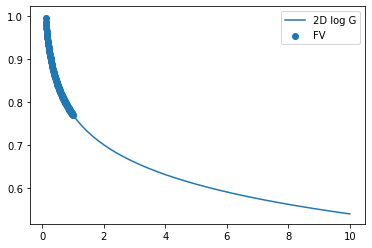

In [15]:

points=10
DD=40
epsilon=0.01
L=1
points_theta=15

for lim in np.array([2000,1000]):
    for R in np.array([0.1,0.2,0.5]):
        for A in np.array([-1,-0.5,-0.3]):
            for B in np.array([1, 0.5,0.25]):
                print("lim={}, R={}, A={}, B={}, p={}".format(lim, R, A, B, points_theta))
                #run_simulations(points, R, epsilon, A, B, L, lim, points_theta, DD)

        
        
#Parameters problem    

points=100

L=1
R=0.1
X=np.linspace(0,L,points)
Y=np.concatenate((np.linspace(R,L,points*10),np.linspace(L,10*L,points)))

epsilon=R/10

#boundary conditions
A=-1 #A represents the derivative
phi_bar=1
q=-A*2*np.pi*R
t=cylindrical_FV_code(L,points,phi_bar,A,R)
FV=t.solve_full_system()

plt.figure()
plt.plot(Y, -q*np.log(Y/R)/(2*np.pi)+phi_bar, label="2D log G")
plt.scatter(t.r,FV, label="FV")
plt.legend()
plt.show()

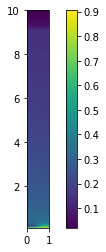

Text(0.5, 1.0, 'Comparison length=4, A=-1, B=1, disc=40')

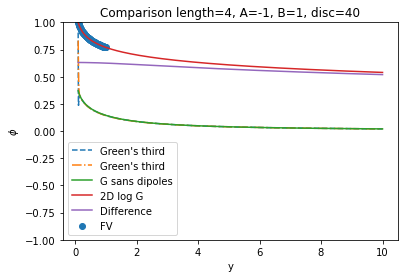

In [16]:


A_dip=np.zeros((len(Y),2))
A_G=np.zeros((len(Y),2))

surf=0
lim=2

DD=40 #discretization per unit length of the axial coordinate of the vessel
p_long=DD*lim #points of discretization of the long tube

cc=0



points_x=np.array((int(points/3), int(points/2)))

d=0
for i in points_x:
    for j in range(len(Y)):
        
        #This loop goes through each surface element on the plane 
        A_dip[j,d], A_G[j,d], dz, dth=almost_inf_tube(lim,np.array([X[i], Y[j], 0]), points_theta, p_long, epsilon,A,phi_bar,R)
    
        bb=np.array([i,j])
        cc+=1
        #print(len(X)*len(Y)-cc)
    d+=1
    
total_surf=2*np.pi*R*lim*2

Difference=-q*np.log(Y/R)/(2*np.pi)+phi_bar+A_G[:,0]

C=+A_dip-A_G
plt.imshow(C, origin="lower",extent=[X[0],X[-1],Y[0],Y[-1]]); plt.colorbar()
plt.show()

plt.plot(Y,C[:,0], '--', label="Green's third")
plt.plot(Y,C[:,1], '-.',label="Green's third")
plt.plot(Y,-A_G[:,0], label="G sans dipoles")
plt.plot(Y, -q*np.log(Y/R)/(2*np.pi)+phi_bar, label="2D log G")
plt.plot(Y, Difference, label="Difference")
plt.scatter(t.r,FV, label="FV")
plt.xlabel("y")
plt.ylabel("$\phi$")
plt.ylim((-np.max([phi_bar, np.max(-A_G)*1.2]),np.max([phi_bar, np.max(-A_G)*1.2])))
plt.legend()
title_figure="Comparison length={}, A={}, B={}, disc={}".format(lim*2, A, phi_bar, DD)
plt.title(title_figure)

0.8907761135375977
0.9018501678927985
0.9122062051355457
0.9217687298210895
0.9304662791060085
0.9382325302810953
0.945007303413673
0.950737440539779
0.955377551213729
0.9588906215567787
0.9612484894807874
0.9624321920653167
0.9624321920653167
0.9612484894807874
0.9588906215567787
0.955377551213729
0.950737440539779
0.945007303413673
0.9382325302810953
0.9304662791060085
0.9217687298210895
0.9122062051355457
0.9018501678927985


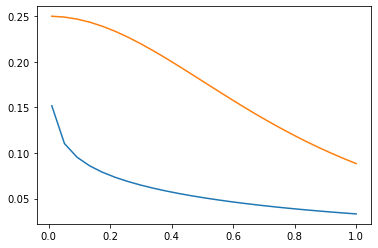

In [17]:
import scipy.special as sp

z=np.linspace(0.01,1,25)

def k(inc_z, R):
    return(1/(np.sqrt(1+(inc_z/R)**2)))

def F(inc_z, R):
    return(0.5*R**2*(inc_z**2+R**2)**(-1.5))


G_bar=np.zeros(len(z))
R=1
c=0
G_bar=sp.ellipk(k(z, R)**2)*k(z,R)/(4*np.pi**2*R)

G_int=np.zeros(len(z))
c=1
for i in z[1:-1]:
    vec_1=z[:c]
    vec_2=z[:-c]
    G_int[c]=np.sum(k(vec_1, R))/25+np.sum(k(vec_2,R))/25
    print(G_int[c])
    c+=1

G_int[[0,-1]]=np.sum(k(z,R))/25

    
plt.plot(z,G_bar)
plt.plot(z, 0.5*F(z, R))

